In [1]:
# Environment Configuration (Optional but Useful)
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [4]:
# Load .ods Spreadsheet File
sheets = pd.read_excel("BMGs-2024.ods", engine="odf", sheet_name=None)

# Extraire uniquement la feuille "Sheet1"
df1 = sheets["Sheet1"]

# Afficher les 10 premières lignes
print(df1.head(10))

   Unnamed: 0                   Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0         NaN                          NaN        NaN        NaN        NaN   
1         NaN          Alloys (compostion)      Tg(K)      Tx(K)      Tl(K)   
2         NaN  Ag30.8 Ca30.8 Mg23.1 Cu15.4        413        432        803   
3         NaN         Ag38.4 Mg30.8 Ca30.8        394        426        805   
4         NaN     Ag38.5 Ca30.8 Mg23 Cu7.7        384        416        854   
5         NaN   Ag38.5 Mg38.5 Ca15.4 Cu7.7        405        436        842   
6         NaN         Ag46.2 Ca30.7 Mg23.1        399        426        765   
7         NaN     Ag46.2 Mg23.2 Ca23 Cu7.7        398        430        825   
8         NaN     Ag50 Ca30.8 Mg11.5 Cu7.7        452        487        809   
9         NaN    Ag53.8 Ca30.5 Mg7.7 Cu7.7        428        488        843   

  Unnamed: 5  Unnamed: 6                  Unnamed: 7 Unnamed: 8 Unnamed: 9  \
0        NaN         NaN                         NaN

In [5]:
# Extract and rename columns from two tables in Sheet1
table1 = df1.iloc[2:][['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']]
table1.columns = ['Alloy', 'Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax(mm)']

table2 = df1.iloc[2:][['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']]
table2.columns = ['Alloy', 'Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax(mm)']

# Combine the two tables
df_combined = pd.concat([table1, table2], ignore_index=True)

# Remove duplicates and rows with missing Alloy values
df_combined = df_combined.drop_duplicates()
df_combined = df_combined.dropna(subset=["Alloy"])

In [6]:
# Save the combined DataFrame to a new Excel file
output_file = "Combined_BMGs_Data.xlsx"
df_combined.to_excel(output_file, index=False)

print(f"The file '{output_file}' has been created successfully.")

# Load and display the first 10 rows of the new file
df_check = pd.read_excel(output_file)
print(df_check.head(10))

The file 'Combined_BMGs_Data.xlsx' has been created successfully.
                         Alloy  Tg(K)  Tx(K)  Tl(K)  Dmax(mm)
0  Ag30.8 Ca30.8 Mg23.1 Cu15.4  413.0  432.0  803.0       2.5
1         Ag38.4 Mg30.8 Ca30.8  394.0  426.0  805.0       0.5
2     Ag38.5 Ca30.8 Mg23 Cu7.7  384.0  416.0  854.0       2.0
3   Ag38.5 Mg38.5 Ca15.4 Cu7.7  405.0  436.0  842.0       0.5
4         Ag46.2 Ca30.7 Mg23.1  399.0  426.0  765.0       0.7
5     Ag46.2 Mg23.2 Ca23 Cu7.7  398.0  430.0  825.0       2.0
6     Ag50 Ca30.8 Mg11.5 Cu7.7  452.0  487.0  809.0       1.0
7    Ag53.8 Ca30.5 Mg7.7 Cu7.7  428.0  488.0  843.0       0.3
8         Ag53.8 Mg15.4 Ca30.8  444.0  498.0  812.0       0.8
9         Ag53.8 Mg23.1 Ca23.1  451.0  488.0  887.0       0.7


In [7]:
# Load the previously saved Excel file
df_cleaned = pd.read_excel("Combined_BMGs_Data.xlsx")

# Drop duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

# Drop rows where all values are NaN (completely empty rows)
df_cleaned = df_cleaned.dropna(how='all')

# Optional: Also drop rows with empty "Alloy" only (keep this if necessary)
df_cleaned = df_cleaned.dropna(subset=["Alloy"])

# Save the cleaned DataFrame back to the same Excel file (overwrite)
df_cleaned.to_excel("Combined_BMGs_Data.xlsx", index=False)

# Display the first 10 rows to confirm
print("Cleaned data (first 10 rows):")
print(df_cleaned.head(10))

Cleaned data (first 10 rows):
                         Alloy  Tg(K)  Tx(K)  Tl(K)  Dmax(mm)
0  Ag30.8 Ca30.8 Mg23.1 Cu15.4  413.0  432.0  803.0       2.5
1         Ag38.4 Mg30.8 Ca30.8  394.0  426.0  805.0       0.5
2     Ag38.5 Ca30.8 Mg23 Cu7.7  384.0  416.0  854.0       2.0
3   Ag38.5 Mg38.5 Ca15.4 Cu7.7  405.0  436.0  842.0       0.5
4         Ag46.2 Ca30.7 Mg23.1  399.0  426.0  765.0       0.7
5     Ag46.2 Mg23.2 Ca23 Cu7.7  398.0  430.0  825.0       2.0
6     Ag50 Ca30.8 Mg11.5 Cu7.7  452.0  487.0  809.0       1.0
7    Ag53.8 Ca30.5 Mg7.7 Cu7.7  428.0  488.0  843.0       0.3
8         Ag53.8 Mg15.4 Ca30.8  444.0  498.0  812.0       0.8
9         Ag53.8 Mg23.1 Ca23.1  451.0  488.0  887.0       0.7


In [8]:
# Display basic info
print("=== DataFrame Info ===")
print(df_cleaned.info())

# Display number of rows and columns
print(f"\nRows: {df_cleaned.shape[0]}, Columns: {df_cleaned.shape[1]}")

# Display column names
print("\n=== Column Names ===")
print(df_cleaned.columns.tolist())

# Display basic statistics for numerical columns
print("\n=== Descriptive Statistics ===")
print(df_cleaned.describe())

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Alloy     697 non-null    object 
 1   Tg(K)     697 non-null    float64
 2   Tx(K)     697 non-null    float64
 3   Tl(K)     697 non-null    float64
 4   Dmax(mm)  697 non-null    float64
dtypes: float64(4), object(1)
memory usage: 27.4+ KB
None

Rows: 697, Columns: 5

=== Column Names ===
['Alloy', 'Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax(mm)']

=== Descriptive Statistics ===
            Tg(K)        Tx(K)        Tl(K)    Dmax(mm)
count  697.000000   697.000000   697.000000  697.000000
mean   614.276758   665.327977  1065.713773    5.224103
std    180.157497   187.743621   278.139736    5.980946
min    341.000000   377.000000   630.000000    0.100000
25%    420.000000   470.000000   774.000000    2.000000
50%    671.000000   731.000000  1145.000000    3.000000
75%    747.000000   800.

In [9]:
from collections import defaultdict

# Function to extract alloy components (same as before)
def extract_alloy_components(alloy_str):
    def parse_group(group_str):
        elements = re.findall(r'([A-Z][a-z]*)([\d.]+)', group_str)
        comp = defaultdict(float)
        for el, val in elements:
            comp[el] += float(val)
        return comp

    def recursive_parse(s):
        stack = []
        comp_stack = []
        multiplier_stack = []
        current = ''
        i = 0
        while i < len(s):
            char = s[i]
            if char in '({[':
                if current:
                    stack.append(current)
                    current = ''
                comp_stack.append({})
                multiplier_stack.append(1)
                stack.append(char)
                i += 1
            elif char in ')}]':
                if current:
                    inner_comp = parse_group(current)
                    comp_stack[-1] = merge_compositions(comp_stack[-1], inner_comp)
                    current = ''
                comp = comp_stack.pop()
                mult_match = re.match(r'([\d.]+)', s[i+1:])
                mult = float(mult_match.group(1)) if mult_match else 1
                i += len(mult_match.group(1)) if mult_match else 0
                scaled = scale_composition(comp, mult)
                if comp_stack:
                    comp_stack[-1] = merge_compositions(comp_stack[-1], scaled)
                else:
                    comp_stack.append(scaled)
                stack.pop()  # remove the opening symbol
                i += 1
            else:
                current += char
                i += 1

        if current:
            final = parse_group(current)
            if comp_stack:
                comp_stack[-1] = merge_compositions(comp_stack[-1], final)
            else:
                comp_stack.append(final)

        return comp_stack[-1] if comp_stack else {}

    def merge_compositions(c1, c2):
        result = defaultdict(float, c1)
        for k, v in c2.items():
            result[k] += v
        return result

    def scale_composition(comp, mult):
        return {k: v * mult / 100 for k, v in comp.items()}

    try:
        flat = recursive_parse(alloy_str)
        total = sum(flat.values())
        if total == 0:
            return None
        normalized = {k: round(100 * v / total, 3) for k, v in flat.items()}
        return normalized
    except:
        return None

# Load the cleaned Excel file
df = pd.read_excel("Combined_BMGs_Data.xlsx")

# Apply the extract_alloy_components function to the 'Alloy' column
df['Alloy'] = df['Alloy'].apply(extract_alloy_components)

# Save the modified DataFrame to a new Excel file
df.to_excel("Combined_BMGs_Data_with_New_Alloy_Compositions.xlsx", index=False)

# Display the first 10 rows to confirm the new file has been created
print(df.head(10))

                                               Alloy  Tg(K)  Tx(K)  Tl(K)  \
0  {'Ag': 30.769, 'Ca': 30.769, 'Mg': 23.077, 'Cu...  413.0  432.0  803.0   
1               {'Ag': 38.4, 'Mg': 30.8, 'Ca': 30.8}  394.0  426.0  805.0   
2    {'Ag': 38.5, 'Ca': 30.8, 'Mg': 23.0, 'Cu': 7.7}  384.0  416.0  854.0   
3  {'Ag': 38.462, 'Mg': 38.462, 'Ca': 15.385, 'Cu...  405.0  436.0  842.0   
4               {'Ag': 46.2, 'Ca': 30.7, 'Mg': 23.1}  399.0  426.0  765.0   
5  {'Ag': 46.154, 'Mg': 23.177, 'Ca': 22.977, 'Cu...  398.0  430.0  825.0   
6    {'Ag': 50.0, 'Ca': 30.8, 'Mg': 11.5, 'Cu': 7.7}  452.0  487.0  809.0   
7  {'Ag': 53.962, 'Ca': 30.592, 'Mg': 7.723, 'Cu'...  428.0  488.0  843.0   
8               {'Ag': 53.8, 'Mg': 15.4, 'Ca': 30.8}  444.0  498.0  812.0   
9               {'Ag': 53.8, 'Mg': 23.1, 'Ca': 23.1}  451.0  488.0  887.0   

   Dmax(mm)  
0       2.5  
1       0.5  
2       2.0  
3       0.5  
4       0.7  
5       2.0  
6       1.0  
7       0.3  
8       0.8  
9       0.7 

In [10]:
# Load the data from the "Combined_BMGs_Data_with_New_Alloy_Compositions.xlsx" file
df = pd.read_excel("Combined_BMGs_Data_with_New_Alloy_Compositions.xlsx")

# 1. Extract alloy components
alloy_data = df['Alloy'].apply(eval).dropna()  # The 'Alloy' column contains dictionaries, so we use eval to interpret them

# 2. Create alloy composition DataFrame
alloy_df = pd.DataFrame(alloy_data.tolist()).fillna(0)

# 3. Clean numerical property columns (based on the filtered rows)
num_cols = ['Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax(mm)']
prop_df = df.loc[alloy_data.index, num_cols].apply(pd.to_numeric, errors='coerce')

# 4. Combine alloy composition and properties into final DataFrame
final_df = pd.concat([alloy_df, prop_df], axis=1).dropna()

# Save the final DataFrame to a new Excel file
final_df.to_excel("Processed_BMGs_Data_with_Alloy_Compositions.xlsx", index=False)

# Display the first 10 rows to confirm the new file has been created
print(final_df.head(10))

       Ag      Ca      Mg      Cu   Au   Si   Pd   Al   Ni   Fe  ...    S  \
0  30.769  30.769  23.077  15.385  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1  38.400  30.800  30.800   0.000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2  38.500  30.800  23.000   7.700  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3  38.462  15.385  38.462   7.692  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
4  46.200  30.700  23.100   0.000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
5  46.154  22.977  23.177   7.692  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
6  50.000  30.800  11.500   7.700  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
7  53.962  30.592   7.723   7.723  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
8  53.800  30.800  15.400   0.000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
9  53.800  23.100  23.100   0.000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

    Be   Sc   Sm    V   Mm  Tg(K)  Tx(K)  Tl(K)  Dmax(mm)  
0  0.0  0.0  0.0  0.0  0.0  413.0  432.0  803.0       2.5  
1  0.0  0.0  0.0  0.0  0.0  394.

In [11]:
# Load the data
df = pd.read_excel("Processed_BMGs_Data_with_Alloy_Compositions.xlsx")

# Define the columns that are not alloy elements
non_alloy_columns = ['Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax(mm)']

# Filter the columns that are alloy elements
alloy_columns = [col for col in df.columns if col not in non_alloy_columns]

# Print the list of alloy elements
print("Éléments chimiques présents dans le fichier :")
print(alloy_columns)

Éléments chimiques présents dans le fichier :
['Ag', 'Ca', 'Mg', 'Cu', 'Au', 'Si', 'Pd', 'Al', 'Ni', 'Fe', 'Zn', 'Ce', 'Ga', 'Nb', 'La', 'Co', 'B', 'Ta', 'Cr', 'C', 'Mo', 'Zr', 'Ti', 'Hf', 'In', 'Y', 'Sn', 'P', 'W', 'Er', 'Mn', 'L', 'Dy', 'Tb', 'Gd', 'Tm', 'Nd', 'Ho', 'Pr', 'S', 'Be', 'Sc', 'Sm', 'V', 'Mm']


In [12]:
# List of valid elements from the periodic table (example subset)
valid_elements = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 
    'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 
    'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'I', 
    'Te', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 
    'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 
    'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 
    'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Uuh'
]

# Load the data
df = pd.read_excel("Processed_BMGs_Data_with_Alloy_Compositions.xlsx")

# Define the columns that are not alloy elements
non_alloy_columns = ['Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax(mm)']

# Filter the columns that are alloy elements
alloy_columns = [col for col in df.columns if col not in non_alloy_columns]

# Remove invalid elements (those not in the periodic table)
valid_alloy_columns = [col for col in alloy_columns if col in valid_elements]

# Print the valid alloy elements
print("Éléments chimiques valides présents dans le fichier :")
print(valid_alloy_columns)

# Optionally, create a new DataFrame with only valid alloy columns
df_valid_alloys = df[valid_alloy_columns + non_alloy_columns]

# Save the filtered DataFrame to a new file
df_valid_alloys.to_excel("Processed_BMGs_Data_with_Valid_Alloy_Compositions.xlsx", index=False)

Éléments chimiques valides présents dans le fichier :
['Ag', 'Ca', 'Mg', 'Cu', 'Au', 'Si', 'Pd', 'Al', 'Ni', 'Fe', 'Zn', 'Ce', 'Ga', 'Nb', 'La', 'Co', 'B', 'Ta', 'Cr', 'C', 'Mo', 'Zr', 'Ti', 'Hf', 'In', 'Y', 'Sn', 'P', 'W', 'Er', 'Mn', 'Dy', 'Tb', 'Gd', 'Tm', 'Nd', 'Ho', 'Pr', 'S', 'Be', 'Sc', 'Sm', 'V']


✅ Le meilleur k  est : 2


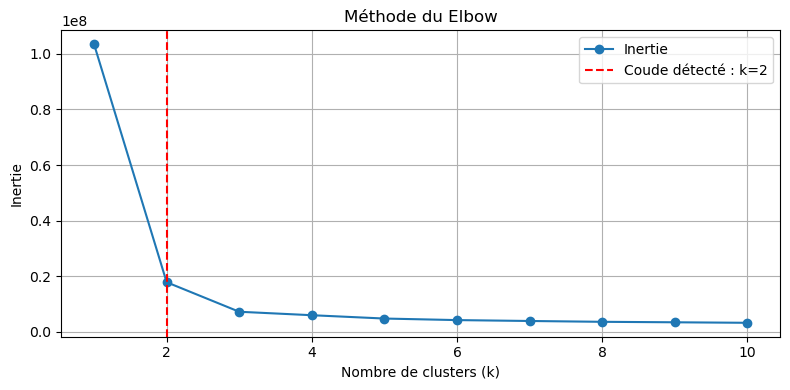

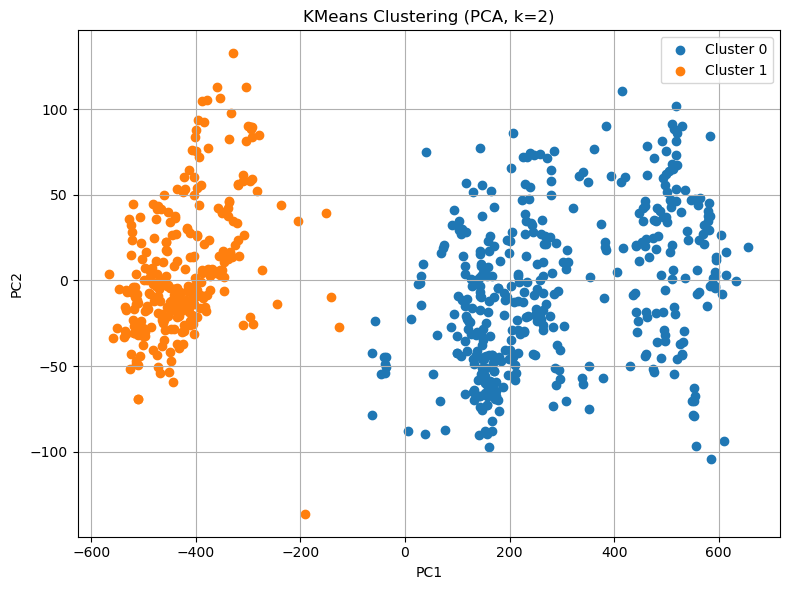

📁 Résultats enregistrés dans : Processed_BMGs_FINAL_with_Clusters.xlsx


In [13]:
from kneed import KneeLocator
# Charger les données
df = pd.read_excel("Processed_BMGs_Data_with_Valid_Alloy_Compositions.xlsx")

# Définir les colonnes chimiques (ici, on suppose que les colonnes chimiques sont déjà identifiées)
exclude_cols = ['Tg', 'Tx', 'Tl', 'Dmax', 'Alloys']  # Exclure les colonnes non pertinentes
element_columns = [col for col in df.columns if col not in exclude_cols]
X = df[element_columns]

# Calculer l'inertie pour différents k
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Trouver le "coude" (k optimal)
kl = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
best_k = kl.elbow
print(f"✅ Le meilleur k  est : {best_k}")

# Affichage Elbow avec point optimal
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, marker='o', label="Inertie")
if best_k:
    plt.axvline(best_k, color='r', linestyle='--', label=f"Coude détecté : k={best_k}")
plt.title("Méthode du Elbow")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Clustering final avec le bon k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X)

# PCA pour affichage
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualisation des clusters après PCA
plt.figure(figsize=(8, 6))
for i in range(best_k):
    plt.scatter(X_pca[df['Cluster'] == i, 0], X_pca[df['Cluster'] == i, 1], label=f"Cluster {i}")
plt.title(f"KMeans Clustering (PCA, k={best_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Sauvegarder les résultats dans un fichier Excel
df.to_excel("Processed_BMGs_FINAL_with_Clusters.xlsx", index=False)
print("📁 Résultats enregistrés dans : Processed_BMGs_FINAL_with_Clusters.xlsx")

In [14]:
from sklearn.metrics import silhouette_score

# Calculer le score de Silhouette pour le clustering final
sil_score = silhouette_score(X, df['Cluster'])
print(f"✅ Le score de Silhouette pour k={best_k} est : {sil_score}")

✅ Le score de Silhouette pour k=2 est : 0.7232683871808933


In [15]:
import pandas as pd

# Load the dataset and print the columns
df = pd.read_excel("Processed_BMGs_Data_with_Valid_Alloy_Compositions.xlsx")

# Print the columns of the dataset
df.columns.tolist()

['Ag',
 'Ca',
 'Mg',
 'Cu',
 'Au',
 'Si',
 'Pd',
 'Al',
 'Ni',
 'Fe',
 'Zn',
 'Ce',
 'Ga',
 'Nb',
 'La',
 'Co',
 'B',
 'Ta',
 'Cr',
 'C',
 'Mo',
 'Zr',
 'Ti',
 'Hf',
 'In',
 'Y',
 'Sn',
 'P',
 'W',
 'Er',
 'Mn',
 'Dy',
 'Tb',
 'Gd',
 'Tm',
 'Nd',
 'Ho',
 'Pr',
 'S',
 'Be',
 'Sc',
 'Sm',
 'V',
 'Tg(K)',
 'Tx(K)',
 'Tl(K)',
 'Dmax(mm)']

Applying clustering to subset: Alloy
Optimal k for Alloy: 4
Silhouette Score for Alloy: 0.3889783262381166


C:\Users\HP\AppData\Local\Temp\ipykernel_15984\3586978252.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data.loc[:, "Cluster"] = labels


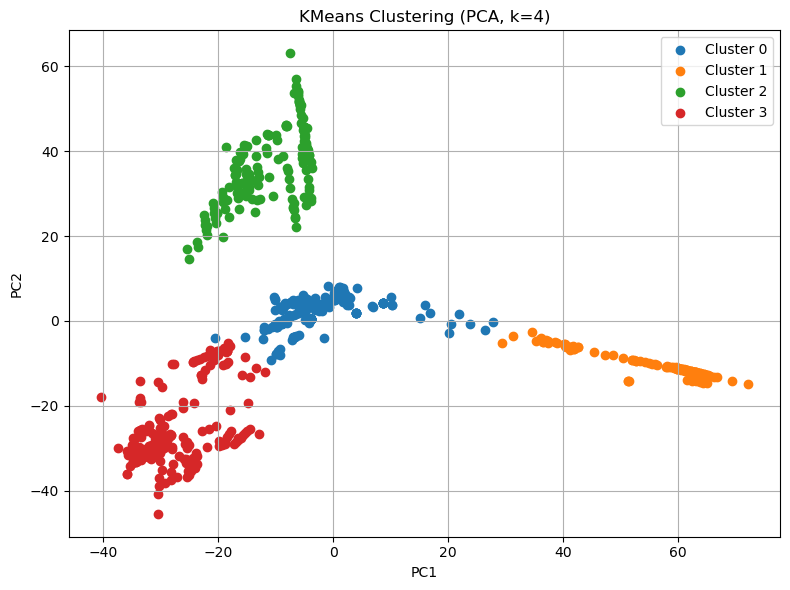

Physical property columns are missing from the subset.
Applying clustering to subset: Alloy + Tg
Optimal k for Alloy + Tg: 2
Silhouette Score for Alloy + Tg: 0.6788645888890815


C:\Users\HP\AppData\Local\Temp\ipykernel_15984\3586978252.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data.loc[:, "Cluster"] = labels


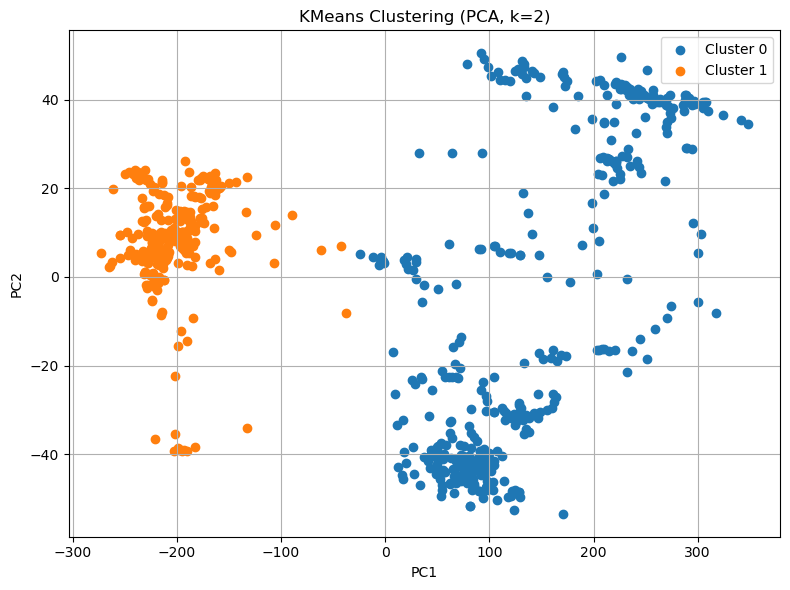

Physical property columns are missing from the subset.
Applying clustering to subset: Alloy + Tg + Tx
Optimal k for Alloy + Tg + Tx: 2
Silhouette Score for Alloy + Tg + Tx: 0.7210181909568985


C:\Users\HP\AppData\Local\Temp\ipykernel_15984\3586978252.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data.loc[:, "Cluster"] = labels


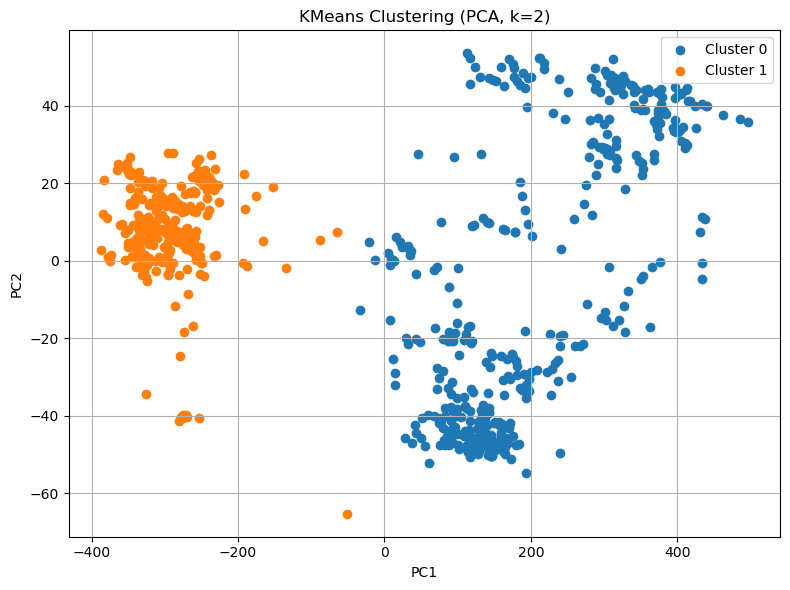

Physical property columns are missing from the subset.
Applying clustering to subset: Full Dataset
Optimal k for Full Dataset: 2
Silhouette Score for Full Dataset: 0.7232683871808933


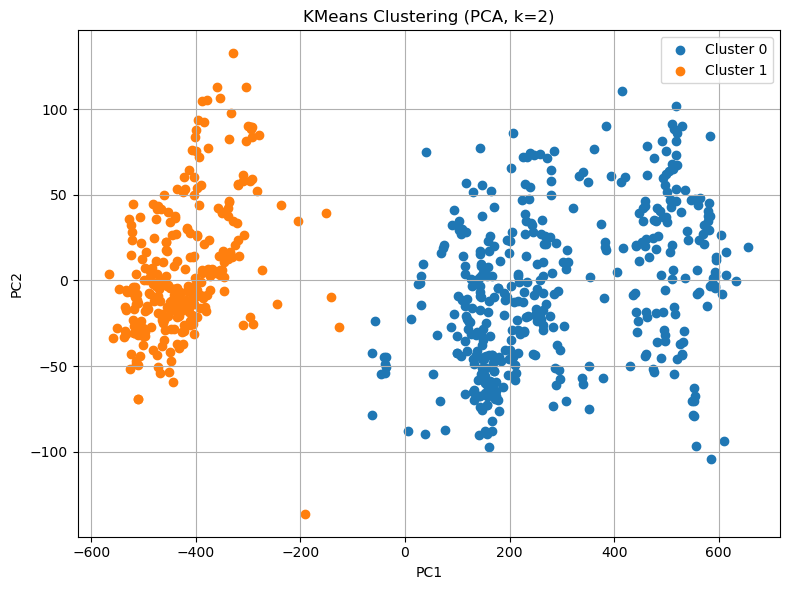

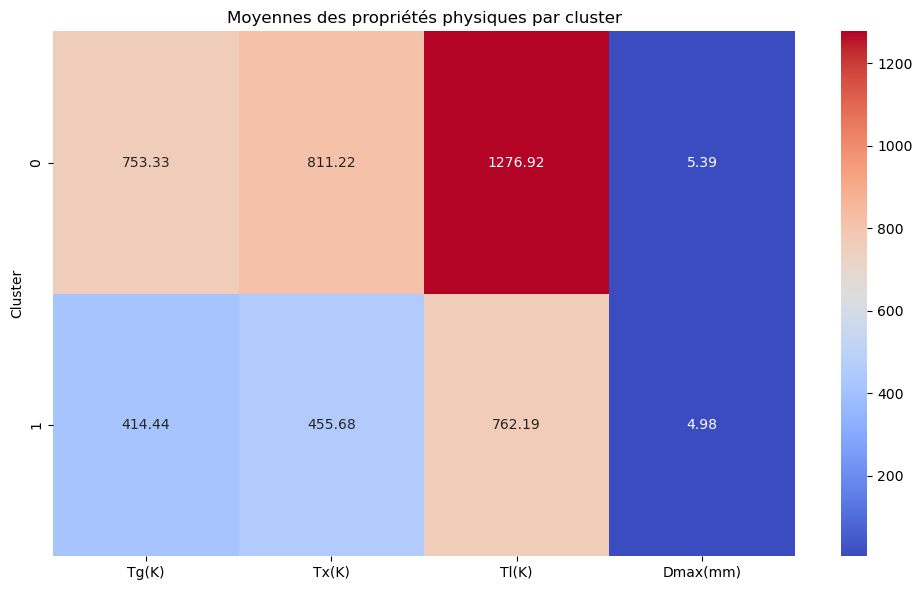


Results for Alloy:
Optimal k: 4
Silhouette Score: 0.3889783262381166

Results for Alloy + Tg:
Optimal k: 2
Silhouette Score: 0.6788645888890815

Results for Alloy + Tg + Tx:
Optimal k: 2
Silhouette Score: 0.7210181909568985

Results for Full Dataset:
Optimal k: 2
Silhouette Score: 0.7232683871808933


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import seaborn as sns
import numpy as np

# Charger les données
df = pd.read_excel("Processed_BMGs_Data_with_Valid_Alloy_Compositions.xlsx")

# Define the columns
exclude_cols = ['Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax(mm)']
element_columns = [col for col in df.columns if col not in exclude_cols]

# Function to calculate the best number of clusters using Elbow Method
def elbow_method(X, k_range=range(1, 11)):
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    kl = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
    return kl.elbow

# Function to compute the silhouette score
def silhouette_score_func(X, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    return silhouette_score(X, labels)

# Function to perform KMeans Clustering and PCA
def kmeans_and_pca(X, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    return labels, X_pca

# Function to visualize the clusters using PCA
def plot_pca(X_pca, labels, k):
    plt.figure(figsize=(8, 6))
    for i in range(k):
        plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], label=f"Cluster {i}")
    plt.title(f"KMeans Clustering (PCA, k={k})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Function to visualize the means of physical properties by cluster
def plot_mean_properties_by_cluster(df):
    # Ensure the physical property columns exist
    if all(col in df.columns for col in ['Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax(mm)']):
        df_grouped = df.groupby("Cluster")[["Tg(K)", "Tx(K)", "Tl(K)", "Dmax(mm)"]].mean()
        plt.figure(figsize=(10, 6))
        sns.heatmap(df_grouped, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Moyennes des propriétés physiques par cluster")
        plt.tight_layout()
        plt.show()
    else:
        print("Physical property columns are missing from the subset.")

# Function to apply KMeans to different subsets and return the results
def apply_clustering_on_subsets(df):
    subsets = {
        'Alloy': df[element_columns],
        'Alloy + Tg': df[element_columns + ['Tg(K)']],
        'Alloy + Tg + Tx': df[element_columns + ['Tg(K)', 'Tx(K)']],
        'Full Dataset': df[element_columns + ['Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax(mm)']]
    }

    results = {}

    for subset_name, subset_data in subsets.items():
        print(f"Applying clustering to subset: {subset_name}")
        
        # Determine optimal number of clusters using Elbow Method
        best_k = elbow_method(subset_data)
        print(f"Optimal k for {subset_name}: {best_k}")
        
        # Compute Silhouette Score
        silhouette = silhouette_score_func(subset_data, best_k)
        print(f"Silhouette Score for {subset_name}: {silhouette}")
        
        # Perform clustering and PCA
        labels, X_pca = kmeans_and_pca(subset_data, best_k)
        
        # Add cluster labels back to the original DataFrame
        subset_data.loc[:, "Cluster"] = labels
        
        # Store results
        results[subset_name] = {
            'best_k': best_k,
            'silhouette_score': silhouette,
            'labels': labels,
            'pca': X_pca
        }
        
        # Visualize the PCA result
        plot_pca(X_pca, labels, best_k)
        plot_mean_properties_by_cluster(subset_data)

    return results

# Apply clustering on all subsets
results = apply_clustering_on_subsets(df)

# Print results summary
for subset_name, result in results.items():
    print(f"\nResults for {subset_name}:")
    print(f"Optimal k: {result['best_k']}")
    print(f"Silhouette Score: {result['silhouette_score']}")